In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy.core.defchararray as npchar
import pickle
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# set initial properties for data location
res = 40000
data_location = "matrices/"
true_location = "trueTADs/"
armatus_location = "./armatus"
out_location = "yielded/"
noise_values = [4, 8, 12, 16, 20]
sim_values = list(range(1, 6))
TAD_callers = ("lava_modularity", "lava_armatus")

In [3]:
# set range of gammas for methods
armatus_gamma = [i / 2 for i in range(11)]
modularity_gamma = list(range(101))
potts_gamma = list(range(41))
corner_gamma = [1,2]
cutoff_values = [10 ** i for i in range(-5, 3, 1)]
window_values = [res * i for i in list(np.arange(0.5, 5, 0.5))]

In [4]:
# set plotting values
sns.set_palette(sns.color_palette("hls", 12))

In [5]:
# custom functions
vector_str = np.vectorize(str)

def TAD_bins(arr1, arr2):
    vector_str = np.vectorize(str)
    return npchar.add(vector_str(arr1), npchar.add(",", vector_str(arr2)))

def TAD_boundaries(arr1, arr2):
    return np.unique(np.append(arr1, arr2))

In [6]:
# load true TADs coordinates
true_TADs = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        print(f"\rnoise={noise} sim={sim}", end="")
        true_TADs.loc[noise, sim] = np.loadtxt(f"{true_location}simHiC_TADintervals_coords_noise{noise}_sim{sim}.txt")
print("\nfinished")

noise=20 sim=5
finished


In [7]:
# combine true TADs coordinates into strings
true_TADs_bins = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_bins.loc[noise, sim] = npchar.add(vector_str(true_TADs.loc[noise, sim][:, 0]), npchar.add(",", vector_str(true_TADs.loc[noise, sim][:, 1])))

In [8]:
# make unique true TADs boundaries
true_TADs_boundaries = pd.DataFrame(index=noise_values, columns=sim_values)
for noise in noise_values:
    for sim in sim_values:
        true_TADs_boundaries.loc[noise, sim] = np.unique(np.append(true_TADs.loc[noise, sim][:, 0], true_TADs.loc[noise, sim][:, 1]))

In [9]:
#TAD_stats = dict.fromkeys(("TPR_bins", "TPR_boundaries", "FDR_bins", "FDR_boundaries"))
stats = ("TPR_bins", "TPR_boundaries", "FDR_bins", "FDR_boundaries")
method_ranges = {"armatus":armatus_gamma, "lava_modularity":modularity_gamma, "lava_armatus":armatus_gamma}
TAD_stats = {stat:{method:{gamma:pd.DataFrame(index=noise_values, columns=sim_values) for gamma in method_ranges[method]} for method in TAD_callers} for stat in stats}

In [20]:
# count TPR and FDR for TADs
# TPR = TP / (TP + FN) = TP / observed_TADs
# FDR = FP / (TP + FP) = FP / true_TADs
for method in TAD_callers:
    for noise in noise_values:
        for sim in sim_values:
            for gamma in method_ranges[method]:
                print(f"\r method={method} noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}{method}_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                TAD_stats["TPR_bins"][method][gamma].loc[noise, sim] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                TAD_stats["FDR_bins"][method][gamma].loc[noise, sim] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                TAD_stats["TPR_boundaries"][method][gamma].loc[noise, sim] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                TAD_stats["FDR_boundaries"][method][gamma].loc[noise, sim] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]

 method=lava_armatus noise=20 sim=5 gamma=5.0100

In [34]:
# Initialize dataframe for plotting lava armatus stats
lava_armatus_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))

In [35]:
# Fill lava_armatus_stats with values
item = 0   
for noise in noise_values:
    for sim in sim_values:
        for gamma in method_ranges["lava_armatus"]:
            for stat in stats:
                print(f"\ritem={item} noise={noise} sim={sim} gamma={gamma}", end="")
                lava_armatus_stats.loc[item, "value"] = TAD_stats[stat]["lava_armatus"][gamma].loc[noise, sim]
                lava_armatus_stats.loc[item, "stat":"gamma"] = [stat, noise, sim, gamma]
                item += 1

item=1099 noise=20 sim=5 gamma=5.0

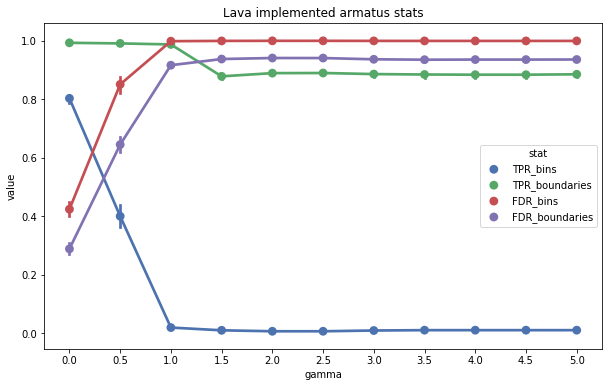

In [37]:
# Plot lava armatus stats
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented armatus stats")
plt.savefig("lava_armatus.png")

Hence, gamma=0 is the best one for lava implemented armatus

In [14]:
lava_modularity_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(modularity_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))

In [87]:
# Fill lava_modularity_stats with values
item = 0   
for noise in noise_values:
    for sim in sim_values:
        for gamma in method_ranges["lava_modularity"]:
            for stat in stats:
                print(f"\ritem={item} noise={noise} sim={sim} gamma={gamma}", end="")
                lava_modularity_stats.loc[item, "value"] = TAD_stats[stat]["lava_modularity"][gamma].loc[noise, sim]
                lava_modularity_stats.loc[item, "stat":"gamma"] = [stat, noise, sim, gamma]
                item += 1

item=10099 noise=20 sim=5 gamma=100

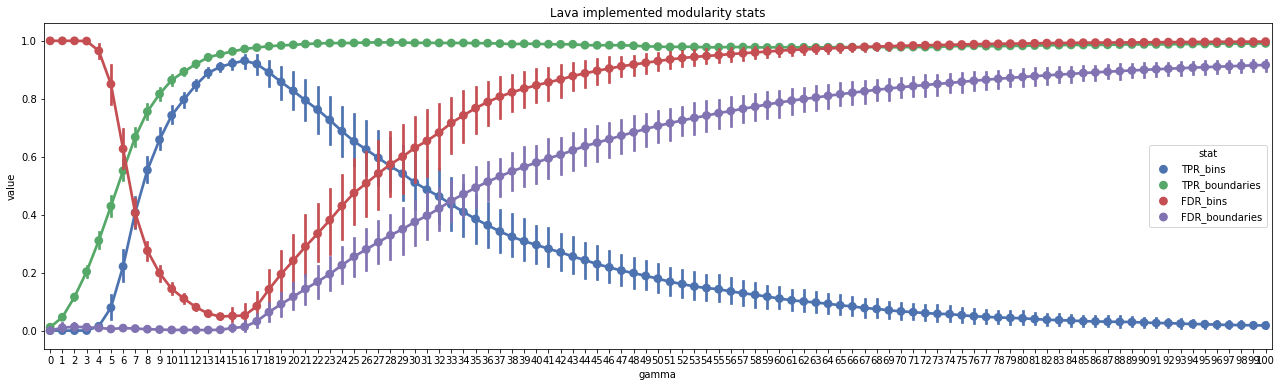

In [88]:
# Plot lava modularity stats
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented modularity stats")
plt.savefig("modularity.png")

In [52]:
#lava modularity stats for all files
lava_modularity_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(modularity_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in modularity_gamma:
                print(f"\r method=lava_modularity noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_modularity_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.median(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_modularity_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["TPR_bins", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["FDR_bins", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["TPR_boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_modularity_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_modularity_stats.loc[item, "stat":"amount"] = ["FDR_boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_modularity_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_modularity noise=20 sim=5 gamma=100

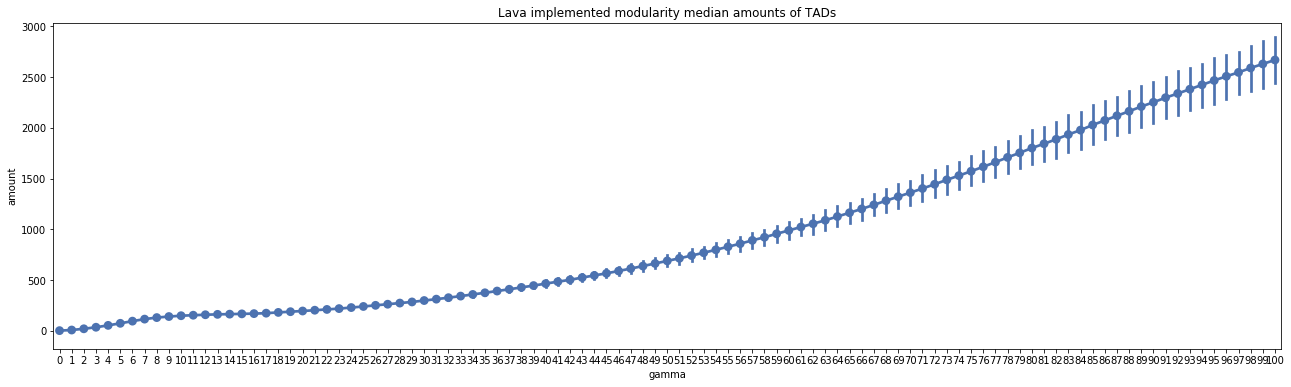

In [42]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="amount")
plt.title("Lava implemented modularity median amounts of TADs")
plt.savefig("lava_modularity_TAD_amount_median.png")

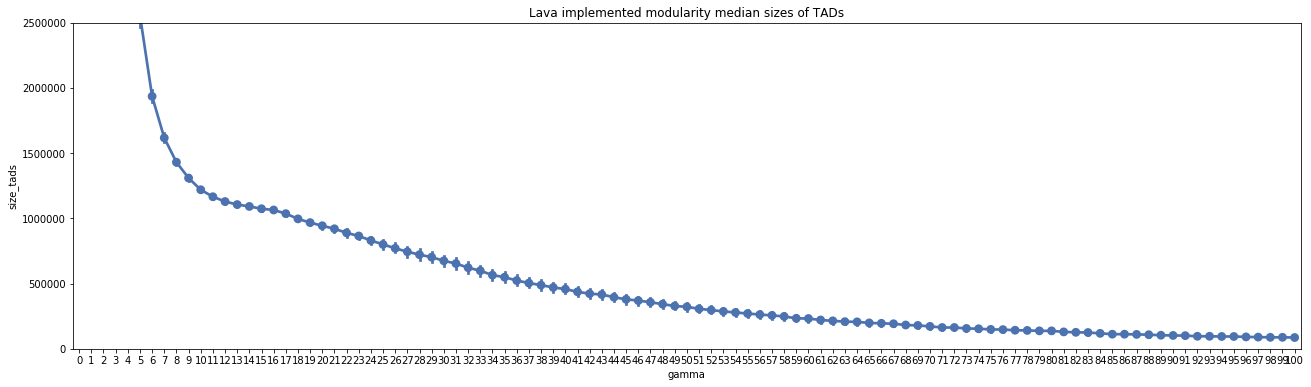

In [48]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_modularity_stats, x="gamma", y="size_tads")
plt.ylim(0, 2500000)
plt.title("Lava implemented modularity median sizes of TADs")
plt.savefig("lava_modularity_TAD_size_median.png")

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


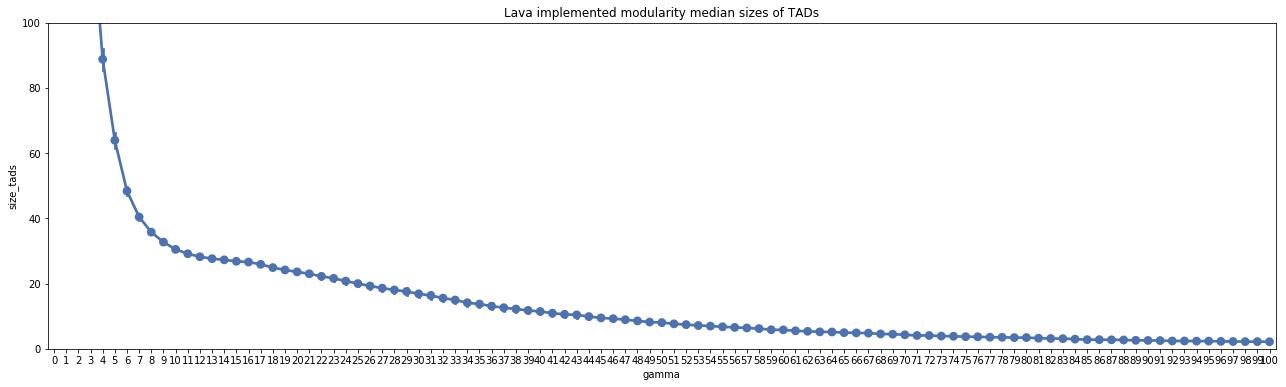

In [55]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
modularity_bins = lava_modularity_stats.loc[:, "gamma":"size_tads"]
modularity_bins["size_tads"] = modularity_bins["size_tads"]
sns.pointplot(data=modularity_bins, x="gamma", y="size_tads")
plt.ylim(0, 100)
plt.title("Lava implemented modularity median sizes of TADs")
plt.savefig("lava_modularity_TAD_size_median_bin.png")

The best gamma for modularity score is 15-16

In [62]:
#lava potts stats for the first file
lava_potts_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(potts_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in potts_gamma:
                print(f"\r method=lava_potts noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_potts_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_potts_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_potts_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_potts_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_potts noise=20 sim=5 gamma=40

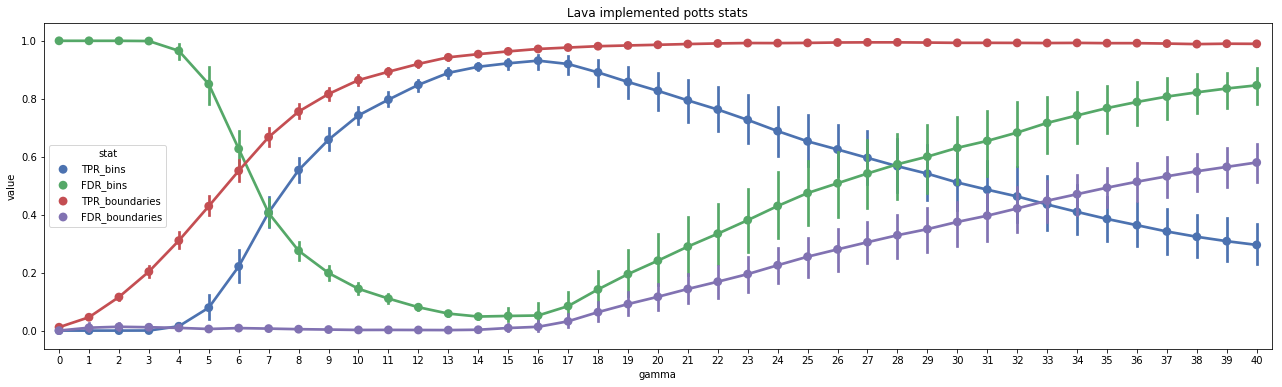

In [66]:
#lava potts stats for the first file
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented potts stats")
plt.savefig("potts.png")

For potts the best gamma is 16

Text(0.5,1,'Lava implemented potts stats')

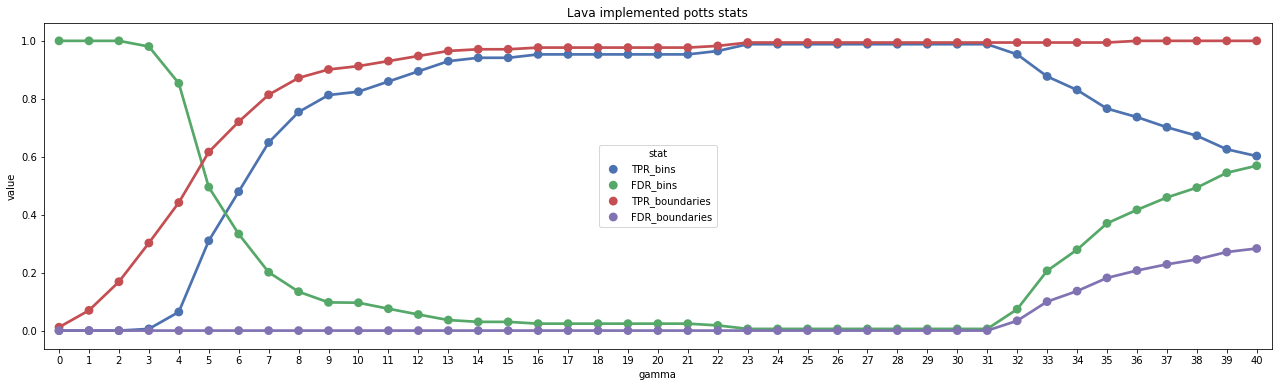

In [65]:
only_1 = lava_potts_stats["noise"] == 4
only_1 &= lava_potts_stats["sim"] == 1
#lava potts stats for the first file
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_potts_stats[only_1], x="gamma", y="value", hue="stat")
plt.title("Lava implemented potts stats")
#plt.savefig("potts_1.png")

In [76]:
#lava variance stats for the first file
lava_variance_stats = pd.DataFrame(index=range(len(range(101)) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in [4]:
    for sim in [1]:
        for gamma in range(101):
                print(f"\r method=lava_variance noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_variance_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_variance_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_variance_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_variance_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_variance noise=4 sim=1 gamma=100

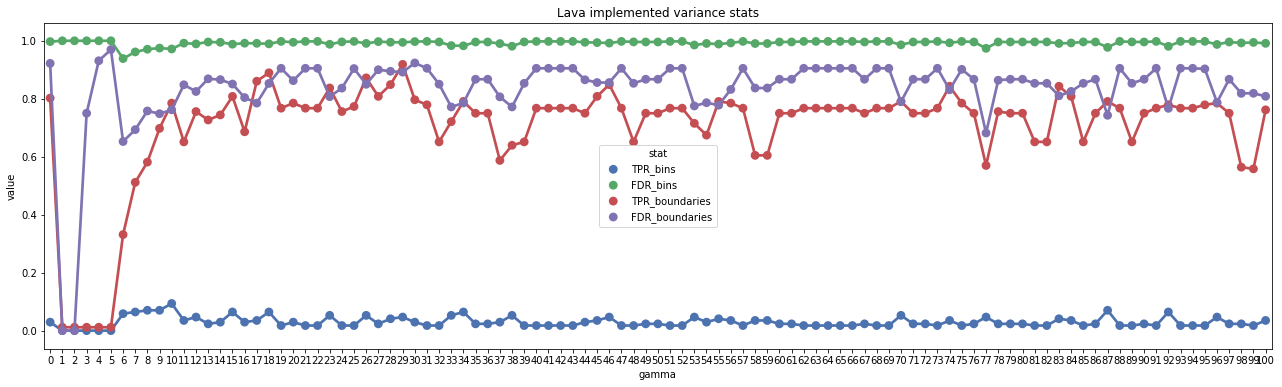

In [83]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_variance_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented variance stats")
plt.savefig("variance_1.png")

In [85]:
#lava corner stats for the first file
lava_corner_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(corner_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in corner_gamma:
                print(f"\r method=lava_corner noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_corner_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_corner_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["TPR_bins", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["FDR_bins", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["TPR_boundaries", noise, sim, gamma]
                item += 1
                lava_corner_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_corner_stats.loc[item, "stat":"gamma"] = ["FDR_boundaries", noise, sim, gamma]
                item += 1

 method=lava_variance noise=20 sim=5 gamma=2

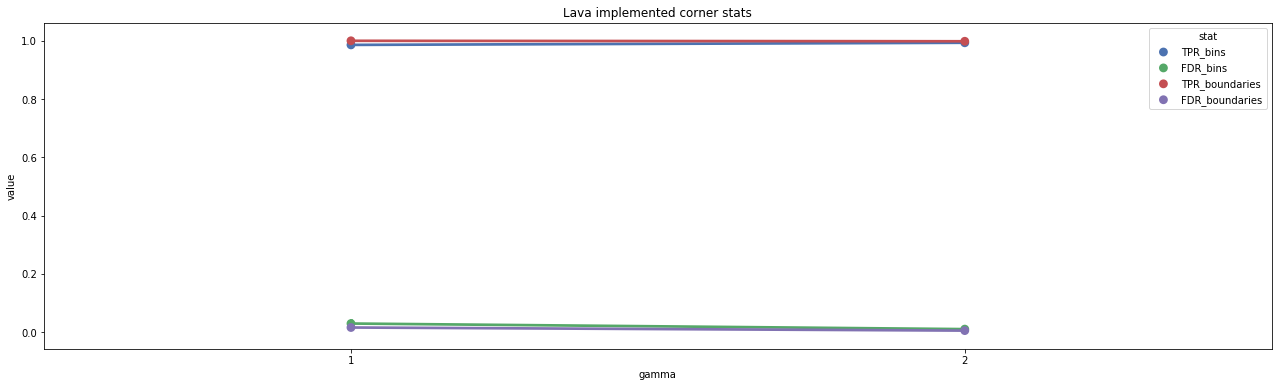

In [86]:
mpl.rcParams['figure.figsize'] = [22, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_corner_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented corner stats")
plt.savefig("corner.png")

For corner, gamma=2 is the best.

In [ ]:
#ii stats for the first file
cutoff_values = list(range(11))
ii_stats = pd.DataFrame(index=range(len(sim_values) * len(noise_values) * len(window_values) * len(cutoff_values) * len(stats)), columns=list(("value", "stat", "window", "cutoff", "sim", "noise")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for window in window_values:
            for cutoff in cutoff_values:
                print(f"\r method=ii noise={noise} sim={sim} window={window} cutoff={cutoff}", end="")
                TADs = np.loadtxt(f"{out_location}ii_noise{noise}_sim{sim}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                if TADs.shape[0] == 0:
                    ii_stats.loc[item, "value"] = 0
                    ii_stats.loc[item, "stat":"noise"] = ["TPR_bins", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = 1
                    ii_stats.loc[item, "stat":"noise"] = ["FDR_bins", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = 0
                    ii_stats.loc[item, "stat":"noise"] = ["TPR_boundaries", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = 1
                    ii_stats.loc[item, "stat":"noise"] = ["FDR_boundaries", window, cutoff, sim, noise]
                    item += 1
                else:
                    bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                    boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                    ii_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                    ii_stats.loc[item, "stat":"noise"] = ["TPR_bins", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                    ii_stats.loc[item, "stat":"noise"] = ["FDR_bins", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                    ii_stats.loc[item, "stat":"noise"] = ["TPR_boundaries", window, cutoff, sim, noise]
                    item += 1
                    ii_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                    ii_stats.loc[item, "stat":"noise"] = ["FDR_boundaries", window, cutoff, sim, noise]
                    item += 1

In [132]:
ii_stats["value"] = np.array(ii_stats["value"], dtype=float)

In [133]:
ii_stats_TPR_bins = ii_stats[ii_stats.stat == "TPR_bins"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)

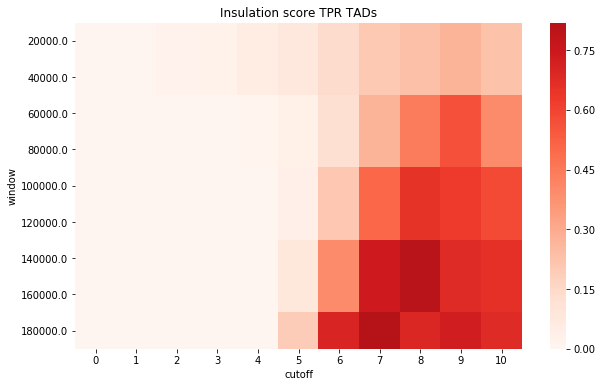

In [135]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_TPR_bins = ii_stats[ii_stats.stat == "TPR_bins"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_TPR_bins, cmap="Reds", center=0.5)
plt.title("Insulation score TPR TADs")
plt.savefig("ii_TPR_TADs.png")

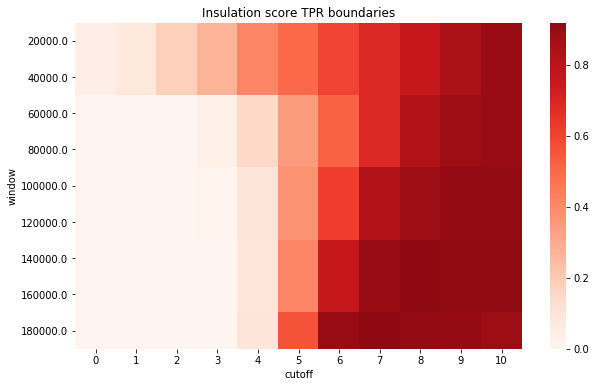

In [136]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_TPR_boundaries = ii_stats[ii_stats.stat == "TPR_boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_TPR_boundaries, cmap="Reds", center=0.5)
plt.title("Insulation score TPR boundaries")
plt.savefig("ii_TPR_boundaries.png")

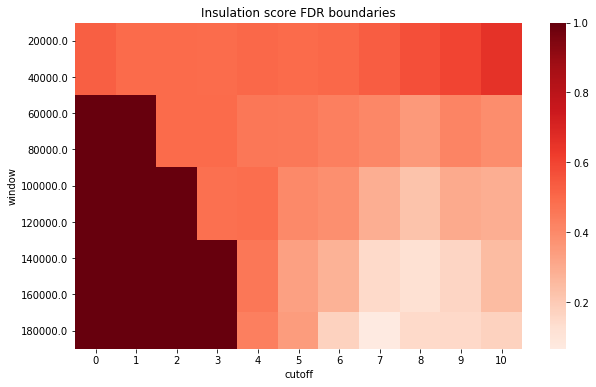

In [137]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_FDR_boundaries = ii_stats[ii_stats.stat == "FDR_boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_FDR_boundaries, cmap="Reds", center=0.5)
plt.title("Insulation score FDR boundaries")
plt.savefig("ii_FDR_boundaries.png")

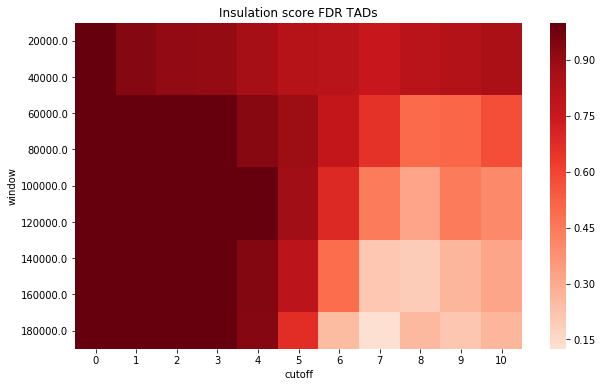

In [190]:
mpl.rcParams['figure.figsize'] = [10, 6]
ii_stats_FDR_bins = ii_stats[ii_stats.stat == "FDR_bins"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(ii_stats_FDR_bins, cmap="Reds", center=0.5)
plt.title("Insulation score FDR TADs")
plt.savefig("ii_FDR_TADs.png")

Insulation score: cutoff = 6-10, window = 3*binsize - 4*binsize

In [10]:
#di stats for the first file
cutoff_values = list(range(5, 16))
window_values = [i * res for i in range(2, 5)]
di_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(window_values) * len(cutoff_values) * len(stats)), columns=list(("value", "stat", "window", "cutoff", "sim", "noise")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for window in window_values:
            for cutoff in cutoff_values:
                print(f"\r method=di noise={noise} sim={sim} window={window} cutoff={cutoff}", end="")
                TADs = np.loadtxt(f"{out_location}di_noise{noise}_sim{sim}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                if TADs.shape[0] == 0:
                    di_stats.loc[item, "value"] = 0
                    di_stats.loc[item, "stat":"noise"] = ["TPR_bins", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = 1
                    di_stats.loc[item, "stat":"noise"] = ["FDR_bins", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = 0
                    di_stats.loc[item, "stat":"noise"] = ["TPR_boundaries", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = 1
                    di_stats.loc[item, "stat":"noise"] = ["FDR_boundaries", window, cutoff, sim, noise]
                    item += 1
                else:
                    bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                    boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                    di_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                    di_stats.loc[item, "stat":"noise"] = ["TPR_bins", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                    di_stats.loc[item, "stat":"noise"] = ["FDR_bins", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                    di_stats.loc[item, "stat":"noise"] = ["TPR_boundaries", window, cutoff, sim, noise]
                    item += 1
                    di_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                    di_stats.loc[item, "stat":"noise"] = ["FDR_boundaries", window, cutoff, sim, noise]
                    item += 1

 method=di noise=20 sim=5 window=160000 cutoff=15

In [11]:
di_stats["value"] = np.array(di_stats["value"], dtype=float)

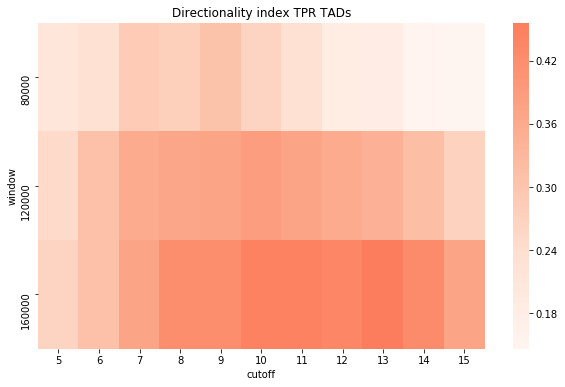

In [16]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_TPR_bins = di_stats[di_stats.stat == "TPR_bins"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_TPR_bins, cmap="Reds", center=0.5)
plt.title("Directionality index TPR TADs")
plt.savefig("di_TPR_TADs_4.png")

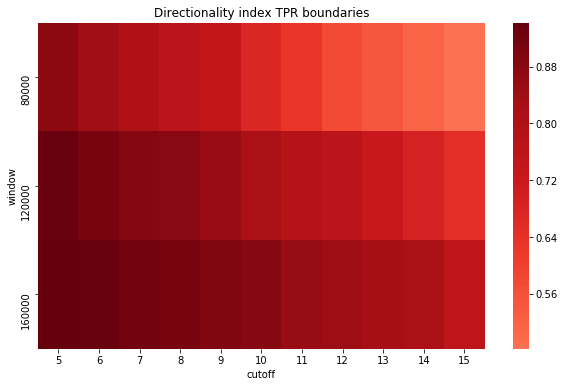

In [17]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_TPR_boundaries = di_stats[di_stats.stat == "TPR_boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_TPR_boundaries, cmap="Reds", center=0.5)
plt.title("Directionality index TPR boundaries")
plt.savefig("di_TPR_boundaries_4.png")

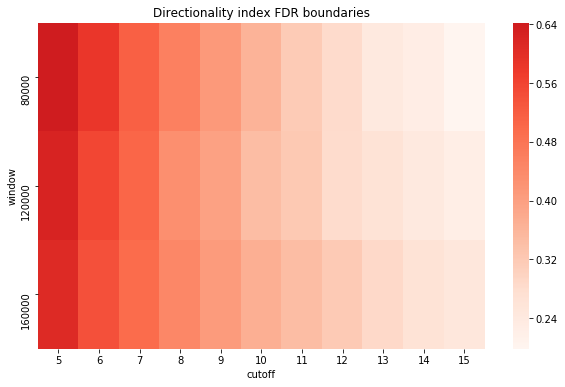

In [18]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_FDR_boundaries = di_stats[di_stats.stat == "FDR_boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_FDR_boundaries, cmap="Reds", center=0.5)
plt.title("Directionality index FDR boundaries")
plt.savefig("di_FDR_boundaries_4.png")

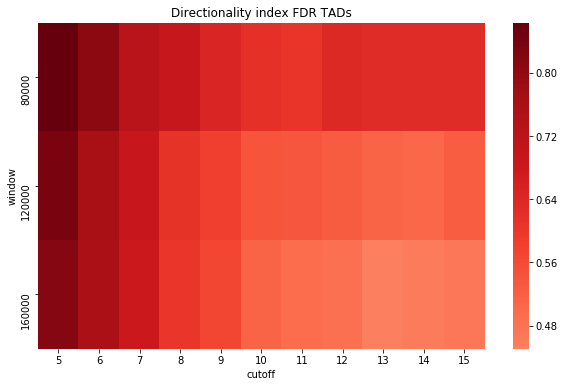

In [19]:
mpl.rcParams['figure.figsize'] = [10, 6]
di_stats_FDR_bins = di_stats[di_stats.stat == "FDR_bins"].pivot_table(index=["window"], columns=["cutoff"], values="value", aggfunc=np.median)
sns.heatmap(di_stats_FDR_bins, cmap="Reds", center=0.5)
plt.title("Directionality index FDR TADs")
plt.savefig("di_FDR_TADs_4.png")

Based on all simulation, best cutoff= 13 - 15, windowsize= 3 * binsize - 4 * binsize

In [20]:
#lava armatus stats for the all files
armatus_gamma = [i / 10 for i in range(-5, 6)]
lava_armatus_stats = pd.DataFrame(index=range(len(noise_values) * len(sim_values) * len(armatus_gamma) * len(stats)), columns=list(("value", "stat", "noise", "sim", "gamma", "amount", "size_tads")))
item = 0
for noise in noise_values:
    for sim in sim_values:
        for gamma in armatus_gamma:
                print(f"\r method=lava_armatus noise={noise} sim={sim} gamma={gamma}", end="")
                TADs = np.loadtxt(f"{out_location}lava_armatus_noise{noise}_sim{sim}_gamma{gamma}.txt", ndmin=2)
                sizes = np.median(TADs[:, 1] - TADs[:, 0])
                bins = TAD_bins(TADs[:, 0], TADs[:, 1])
                boundaries = TAD_boundaries(TADs[:, 0], TADs[:, 1])
                lava_armatus_stats.loc[item, "value"] = sum(np.isin(bins, true_TADs_bins.loc[noise, sim])) / true_TADs_bins.loc[noise, sim].shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["TPR_bins", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(~np.isin(bins, true_TADs_bins.loc[noise, sim])) / bins.shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["FDR_bins", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / true_TADs_boundaries.loc[noise, sim].shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["TPR_boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1
                lava_armatus_stats.loc[item, "value"] = sum(~np.isin(boundaries, true_TADs_boundaries.loc[noise, sim])) / boundaries.shape[0]
                lava_armatus_stats.loc[item, "stat":"amount"] = ["FDR_boundaries", noise, sim, gamma, TADs.shape[0]]
                lava_armatus_stats.loc[item, "size_tads"] = sizes
                item += 1

 method=lava_armatus noise=20 sim=5 gamma=0.51

In [202]:
np.median(lava_armatus_stats.size_tads)

600000.0

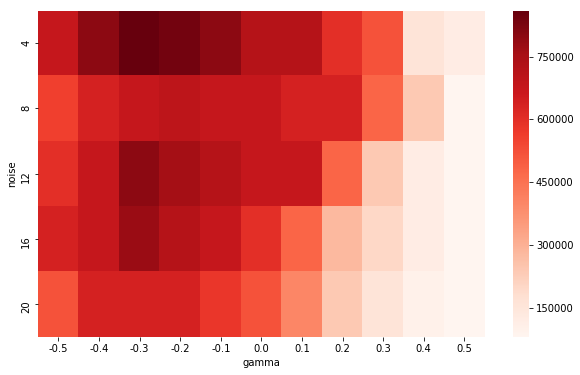

In [208]:
lava_armatus_stats["amount"] = np.array(lava_armatus_stats["amount"], dtype=int)
lava_armatus_stats["value"] = np.array(lava_armatus_stats["value"], dtype=float)
lava_armatus_stats["size_tads"] = np.array(lava_armatus_stats["size_tads"], dtype=float)
armatus_sizes = lava_armatus_stats[lava_armatus_stats.stat == "TPR_bins"].pivot_table(index=["noise"], columns=["gamma"], values="size_tads", aggfunc=np.median)
sns.heatmap(armatus_sizes, cmap="Reds")

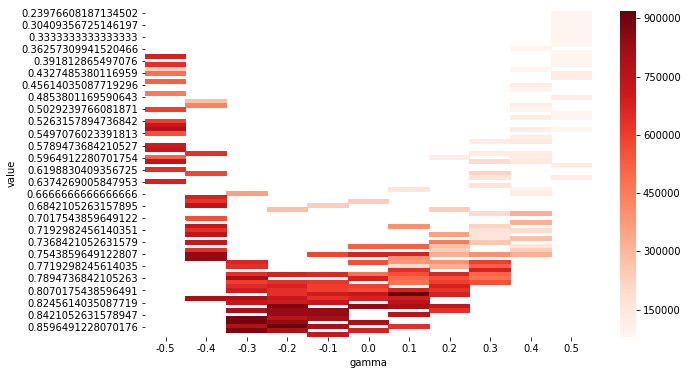

In [216]:
armatus_sizes = lava_armatus_stats[lava_armatus_stats.stat == "TPR_bins"].pivot_table(index=["value"], columns=["gamma"], values="size_tads", aggfunc=np.median)
sns.heatmap(armatus_sizes, cmap="Reds")

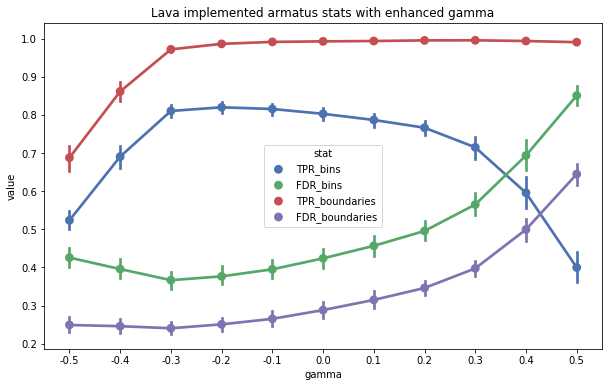

In [117]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="value", hue="stat")
plt.title("Lava implemented armatus stats with enhanced gamma")
plt.savefig("lava_armatus_enhanced.png")

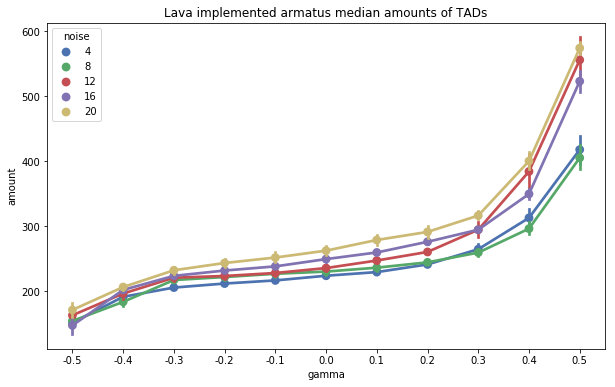

In [43]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="amount", hue="noise")
plt.title("Lava implemented armatus median amounts of TADs")
plt.savefig("lava_armatus_TAD_amount_noise.png")

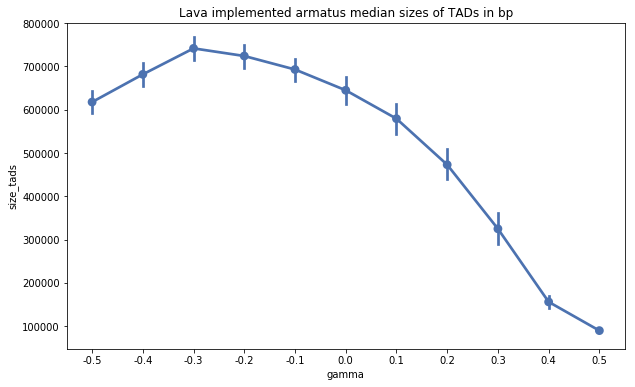

In [25]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("deep"))
sns.pointplot(data=lava_armatus_stats, x="gamma", y="size_tads")
plt.title("Lava implemented armatus median sizes of TADs in bp")
plt.savefig("lava_armatus_TAD_size_bp.png")

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


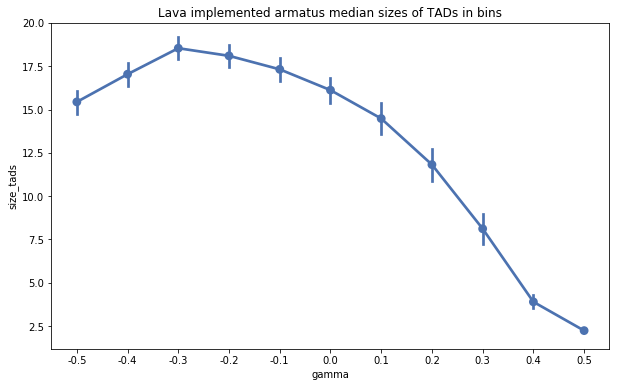

In [29]:
lava_armatus_sizes = lava_armatus_stats.loc[:, "gamma":"size_tads"]
lava_armatus_sizes["size_tads"] = lava_armatus_sizes["size_tads"] / res
sns.pointplot(data=lava_armatus_sizes, x="gamma", y="size_tads")
plt.title("Lava implemented armatus median sizes of TADs in bins")
plt.savefig("lava_armatus_TAD_size_bin.png")

The best one gamma for armatus in lavaburst is -0.3. The best gamma corresponds to the biggest median size of TADs. 

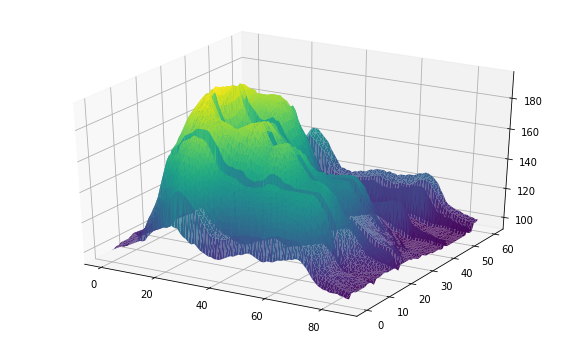

In [34]:
# Get the data (csv file is hosted on the web)
url = 'https://python-graph-gallery.com/wp-content/uploads/volcano.csv'
data = pd.read_csv(url)
 
# Transform it to a long format
df=data.unstack().reset_index()
df.columns=["X","Y","Z"]
 
# And transform the old column name in something numeric
df['X']=pd.Categorical(df['X'])
df['X']=df['X'].cat.codes
 
# Make the plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
plt.show()
 
# to Add a color bar which maps values to colors.
surf=ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar( surf, shrink=0.5, aspect=5)
plt.show()
 
# Rotate it
ax.view_init(30, 45)
plt.show()
 
# Other palette
ax.plot_trisurf(df['Y'], df['X'], df['Z'], cmap=plt.cm.jet, linewidth=0.01)
plt.show()


In [35]:
df

,X,Y,Z
0,0,0,100
1,0,1,101
2,0,2,102
3,0,3,103
4,0,4,104
5,0,5,105
6,0,6,105
7,0,7,106
8,0,8,107
9,0,9,108
